# Getting Data

In [1]:
%%writefile kaggle.json
{"username":"rushikeshdarge","key":"********************************"}

Writing kaggle.json


In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c learn-ai-bbc
! unzip /content/learn-ai-bbc.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/1.85M [00:00<?, ?B/s]
100% 1.85M/1.85M [00:00<00:00, 143MB/s]
Archive:  /content/learn-ai-bbc.zip
  inflating: BBC News Sample Solution.csv  
  inflating: BBC News Test.csv       
  inflating: BBC News Train.csv      


In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [4]:
df = pd.read_csv('/content/BBC News Train.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
df.shape

(1490, 3)

In [6]:
df.Category.value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [7]:
df.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [8]:
df.Text.sample(10)

730     russia wto talks  make progress  talks on russ...
438     pupils to get anti-piracy lessons lessons on m...
974     butler strikes gold in spain britain s kathy b...
1481    liverpool pledge to keep gerrard liverpool chi...
870     farrell due to make us tv debut actor colin fa...
509     virus poses as christmas e-mail security firms...
36      corry backs skipper robinson england forward m...
1314    rem concerts blighted by illness us rock band ...
1072    games maker fights for survival one of britain...
68      us state acts to stop  spammers  us state texa...
Name: Text, dtype: object

# Pre-Processing

In [9]:
# ref : from reference notebook
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    text = re.sub('-', ' ', text)
    return text

df['Text'] = df['Text'].apply(preprocess)
df.head()

,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in 168m payout eighteen former en...,business


In [10]:
df = df[['Text', 'Category']]
df.head()

,Text,Category
0,worldcom exboss launches defence lawyers defen...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in 168m payout eighteen former en...,business


# Prepare data for model

In [11]:
X = df.Text
y = df.Category

In [12]:
# split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1341,), (149,), (1341,), (149,))

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
token = Tokenizer(num_words=10000, oov_token='unk')
token.fit_on_texts(X_train.values)
data_xtrain = token.texts_to_sequences(X_train.values)
data_xtest = token.texts_to_sequences(X_test.values)

In [85]:
# saving tokenizer for deploying model
# ref : https://stackoverflow.com/a/45737582
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     token = pickle.load(handle)

In [16]:
print('Number of unique words',len(token.word_index.keys()))

Number of unique words 26061


Text(0.5, 0, 'length')

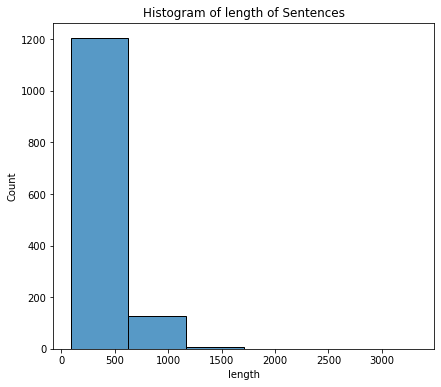

In [17]:
leng = [len(ele) for ele in data_xtrain]
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.histplot(leng, bins=6)
plt.title("Histogram of length of Sentences")
plt.xlabel("length")

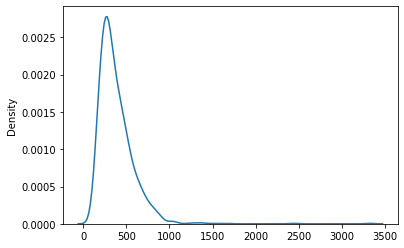

In [18]:
sns.kdeplot(leng)

In [19]:
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(leng, i)))

10 Quantile is 192.0
20 Quantile is 232.0
30 Quantile is 264.0
40 Quantile is 298.0
50 Quantile is 331.0
60 Quantile is 384.0
70 Quantile is 435.0000000000001
80 Quantile is 507.0
90 Quantile is 630.0
100 Quantile is 3324.0


* We take 80 Quantile as words which is 507 we round up and take 500

In [20]:
max_len = 500
# padding
data_xtrain_pad = pad_sequences(data_xtrain, maxlen=max_len, padding='post', dtype='int32')
data_xtest_pad = pad_sequences(data_xtest, maxlen=max_len, padding='post', dtype='int32')

In [21]:
data_xtrain_pad.shape

(1341, 500)

In [22]:
index = 50
print('text: ',X_train[0][:index])
print('\n text to num: ',data_xtrain[0][:index])
print('\n num to padded: ',data_xtrain_pad[0][:index])

text:  worldcom exboss launches defence lawyers defending

 text to num:  [1160, 1139, 1003, 3, 5929, 2, 1160, 1139, 23, 329, 7, 677, 5930, 41, 60, 3665, 48, 2, 77, 20, 440, 2345, 457, 16, 736, 22, 523, 5929, 33, 1228, 47, 28, 9626, 100, 751, 3, 1476, 49, 8270, 23, 16, 736, 9627, 2, 8271, 255, 28, 2, 588, 325]

 num to padded:  [1278 2582  717  752  149   27  786  319  298    3 3315  161   74  238
  139 5935    5 4675    1 1536   27   70 2206    6  983 1098 3883   27
  181   11  158  319  148    5  468  143  139    1    6 1160 1139   83
  744   48 8281    3 5486    4 7271   64]


# Model Building

In [39]:
from tensorflow.keras.layers import Embedding, LSTM, Input, Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import Model

In [24]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()
y_train_class = lenc.fit_transform(y_train)
y_test_class = lenc.transform(y_test)

y_train_class = to_categorical(y_train_class, num_classes=5)

In [25]:
data_xtrain_pad.shape

(1341, 500)

In [33]:
embed_input = len(token.word_index.keys()) + 1

In [44]:
# train acc = 41 te = 35
input = Input(shape=(max_len,))
embed = Embedding(embed_input, 128)(input)
lstm1 = LSTM(100, return_sequences=True, return_state=False)(embed)
lstm2 = LSTM(50, dropout=0.2)(lstm1)
dense1 = Dense(50)(lstm2)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(24)(drop1)
dense3 = Dense(5, activation='softmax')(dense2)

model = Model(inputs=input, outputs=dense3)

In [45]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 500, 128)          3335936   
                                                                 
 lstm_7 (LSTM)               (None, 500, 100)          91600     
                                                                 
 lstm_8 (LSTM)               (None, 50)                30200     
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 24)                1224

In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)

history = model.fit(data_xtrain_pad, y_train_class, validation_split=0.1, epochs=70, use_multiprocessing=True)

Epoch 1/70
38/38 [==============================] - 6s 64ms/step - loss: 1.5828 - accuracy: 0.2537 - val_loss: 1.5103 - val_accuracy: 0.3037
Epoch 2/70
38/38 [==============================] - 2s 41ms/step - loss: 1.5499 - accuracy: 0.2861 - val_loss: 1.5131 - val_accuracy: 0.3111
Epoch 3/70
38/38 [==============================] - 2s 42ms/step - loss: 1.5848 - accuracy: 0.2944 - val_loss: 1.4995 - val_accuracy: 0.3111
Epoch 4/70
38/38 [==============================] - 2s 42ms/step - loss: 1.5581 - accuracy: 0.3549 - val_loss: 1.6988 - val_accuracy: 0.1778
Epoch 5/70
38/38 [==============================] - 2s 44ms/step - loss: 1.4914 - accuracy: 0.3192 - val_loss: 1.4759 - val_accuracy: 0.3556
Epoch 6/70
38/38 [==============================] - 2s 42ms/step - loss: 1.3885 - accuracy: 0.3872 - val_loss: 1.4497 - val_accuracy: 0.3704
Epoch 7/70
38/38 [==============================] - 2s 42ms/step - loss: 1.6401 - accuracy: 0.3375 - val_loss: 1.4799 - val_accuracy: 0.3111
Epoch 8/70
38

In [65]:
model.save('news_model.h5')

# Testing performance of model

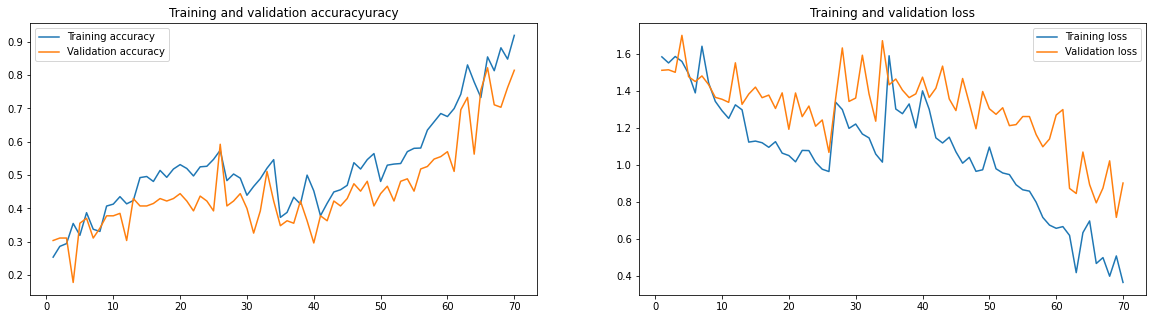

In [64]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(20,5))
plt.subplot(121)
sns.lineplot(epochs, accuracy, label='Training accuracy')
sns.lineplot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()


plt.subplot(122)
sns.lineplot(epochs, loss, label='Training loss')
sns.lineplot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [72]:
y_true = lenc.transform(y_test)
y_pred = model.predict(data_xtest_pad)
y_pred = np.argmax(y_pred,axis=1)

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = lenc.classes_
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

     business       0.80      0.83      0.81        42
entertainment       0.61      0.71      0.65        24
     politics       0.92      0.79      0.85        28
        sport       1.00      1.00      1.00        26
         tech       0.96      0.90      0.93        29

     accuracy                           0.85       149
    macro avg       0.86      0.84      0.85       149
 weighted avg       0.86      0.85      0.85       149



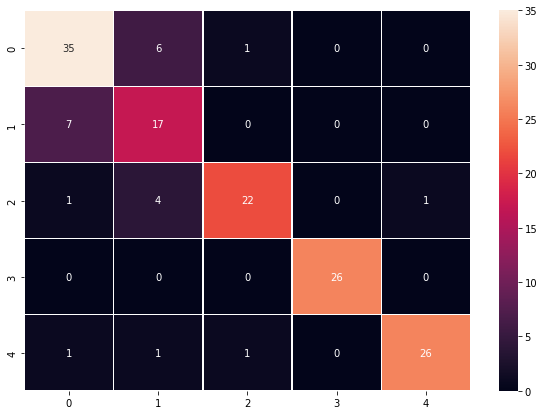

In [84]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, linewidths=.5)

# Pipeline

In [166]:
from tensorflow.keras.models import load_model 
news_model = load_model('/content/news_model.h5')

In [167]:
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    token = pickle.load(handle)

In [168]:
classes = ['business', 'entertainment', 'politics', 'sport', 'tech']

In [169]:
# ref : https://economictimes.indiatimes.com/markets/stocks/news/stocks-in-the-news-wipro-indusind-bank-srf-havells-ntpc-and-yes-bank/articleshow/93016213.cms
new_news = '''Wipro: The IT major reported a 21 per cent decline in its June quarter net profit as higher employee-related costs pushed up the firm's overall expenses. Consolidated net profit at Rs 2,563.6 crore in April-June was 20.6 per cent, lower than Rs 3,242.6 crore net profit in the same period a year back.
NTPC: The state-owned power giant has inked a pact with Moroccan Agency for Sustainable Energy (MASEN) for cooperation in renewable energy. It signed an MoU with MASEN for cooperation in the renewable energy sector during the 17th CII EXIM Conclave on India Africa Growth Partnership held in New Delhi from 19th-20th July 2022.'''

In [170]:
# apply preprocessing
new_news = preprocess(new_news)
# to create make suitable for model
new_news = new_news , '''news'''

# text to num
news_text = token.texts_to_sequences(new_news)
# padding
max_len = 500
news_text_pad = pad_sequences(news_text, maxlen=max_len, padding='post', dtype='int32')

In [172]:
classes[np.argmax(news_model.predict(new_text_pad)[0])]

'business'

# Future Work

- we have very less data we can increase the size of dataset and also we can add more categories